In [ ]:
#Now unlock the robot:
await node.unlock()

In [ ]:
## How to set robot variables
rt.stop()
v = {
    "motor.left.target": [0],
    "motor.right.target": [0],
}
await node.set_variables(v)


# Test run of whole project

In [ ]:
# import tdmclient.notebook
# await tdmclient.notebook.start()

In [ ]:
#%%run_python

#v =[0,0]
#leds_prox_v = v
# "leds.prox.v": [0,0]
#node.send_set_variables("leds.prox.v")

In [ ]:
# await tdmclient.notebook.stop()

In [1]:
%run src\project\Global_nav.py
%run src\project\DetectionFcts.py
%run src\project\Locomotion.py

In [2]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 2c7350d0-9e66-4eb8-9b25-c07ee89089f8

In [3]:
def main(checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) :
    global current_checkpoint_index, fsm_state, cam_available, cam_data, x_est_prev, P_est_prev, reached_end
    # we can remove cam_data and cam_available once everything is integrated
    """
    Main function which coordinates the whole application
    
    global : takes the variables that will be changed throughout the application
    
    param checkpoints_data: velocity of left wheel as decided by control law in metric [mm/s]
    param Q: Q matrix for the Kalman Filter
    param R: R matrix for the Kalman Filter
    param Ts: Period for the Python thread which uses the main(...) function
    
    no return 
    """
    if webcam:
        success,img = cap.read()
        cam_available = True
    else: 
        cam_available = False
        #img=cv2.imread(path)
    
    if cam_available:
        Thymio_coord, Thymio_found = analyse_thymio(img,contours, area_max, m.ratio_downscale)
        
    # Thymio_found = False
    #rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # this converts it into RGB
    #plt.figure(figsize=(7,7))
    #plt.imshow(rgb_img)
    #plt.show()
    
    # Thymio_coord = (Thymio_coord[0], m.ratio_total*m.height/1.04 - Thymio_coord[1], -Thymio_coord[2] )
    corrected_estimate_angle = -Thymio_coord[2]
    if corrected_estimate_angle < 0 :
        corrected_estimate_angle = corrected_estimate_angle +2*math.pi
    
    if (Thymio_found):
        Thymio_coord = (Thymio_coord[0]*m.ratio_total, (m.height-Thymio_coord[1])*m.ratio_total, -Thymio_coord[2])
        #print('m.height : '+str(m.height) + '\n')
        # Thymio_pos = np.array([Thymio_coord[0]*1.04, Thymio_coord[1]*1.04, Thymio_coord[2]])
    else:
        Thymio_coord = np.array([0,0,0])
    print('Angle Thymio : '+str(corrected_estimate_angle) + '\n')
    print ('Camera x :' + str(Thymio_coord[0]) + ', Camera y :' + str(Thymio_coord[1]) +'\n')
    sensor_data = np.array(node.v.prox.horizontal[0:5]) #get data from horiz proximity sensors
    
    [left_velocity, right_velocity, fsm_state, current_checkpoint_index, reached_end] = control_law(sensor_data, checkpoints_data, current_checkpoint_index, fsm_state, x_est_prev, Thymio_found)
    print('Checkpoint number : '+str(current_checkpoint_index) + '\n')
    print('FSM state : '+str(fsm_state) + '\n \n')
    speed = [left_velocity, right_velocity]
    
    [x_est_prev, P_est_prev] = kalman_filter(speed, Thymio_found, Thymio_coord, x_est_prev, P_est_prev, Q, R, Ts)
    
    node.send_set_variables(motors(left_velocity, right_velocity))
    cam_avaiable = False 
    Thymio_found = False

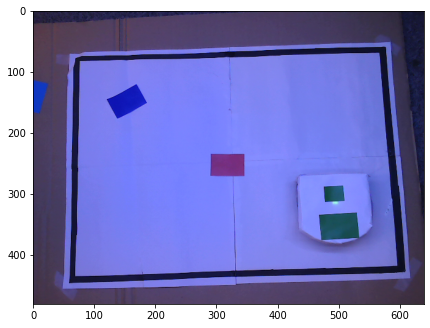

Bonne image ? : (press enter)n


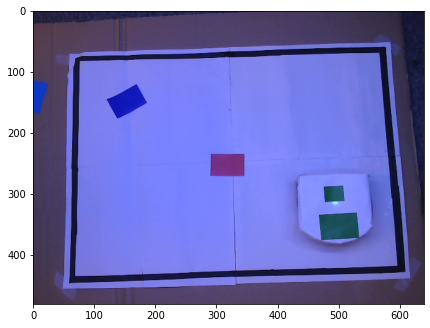

Bonne image ? : (press enter)n


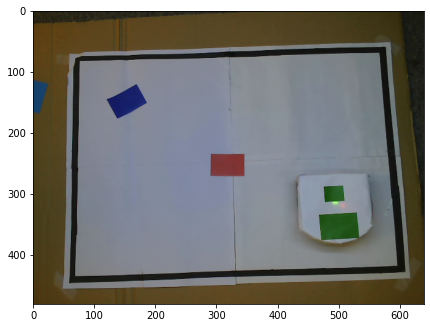

Bonne image ? : (press enter)n


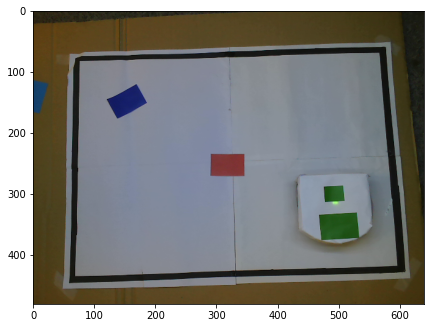

Bonne image ? : (press enter)y


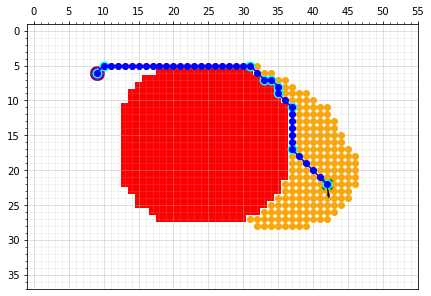

Bonne analyse ? : (press enter)y
Angle Thymio : 4.843704419367778

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 278.13010235415595

Angle wanted : 270.0

Checkpoint number : 1

FSM state : rotating
 

Angle Thymio : 4.831817906403028

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 277.5238204386386

Angle wanted : 135.00000000000003

Checkpoint number : 1

FSM state : rotating
 

Angle Thymio : 4.79384102469056

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 276.84277341263095

Angle wanted : 135.00000000000003

Checkpoint number : 1

FSM state : rotating
 

Thymio not found
Angle Thymio : 0

Camera x :0.0, Camera y :377.37806324110664

Position x :428.3750988142292, Position y :152.991106719


Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 190.61965527615516

Angle wanted : 135.00000000000003

Checkpoint number : 1

FSM state : rotating
 

Angle Thymio : 3.1823863364576583

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 186.9810574068298

Angle wanted : 135.00000000000003

Checkpoint number : 1

FSM state : rotating
 

Angle Thymio : 3.1207623335535764

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 182.3373058591238

Angle wanted : 135.00000000000003

Checkpoint number : 1

FSM state : rotating
 

Angle Thymio : 3.019750216569876

Camera x :428.3750988142292, Camera y :152.99110671936756

Position x :428.3750988142292, Position y :152.99110671936756

Estimated orientation : 178.806

Angle Thymio : 1.9124118174427038

Camera x :397.77687747035566, Camera y :214.1875494071146

Position x :397.77687747035566, Position y :214.1875494071146

Estimated orientation : 109.17900802581073

Angle wanted : 111.80140948635182

Checkpoint number : 2

FSM state : moving
 

Thymio not found
Angle Thymio : 0

Camera x :0.0, Camera y :377.37806324110664

Position x :397.77687747035566, Position y :214.1875494071146

Estimated orientation : 109.57312583041019

Angle wanted : 111.80140948635182

Checkpoint number : 2

FSM state : moving
 

Angle Thymio : 1.9124118174427038

Camera x :397.77687747035566, Camera y :214.1875494071146

Position x :0.0, Position y :377.37806324110664

Estimated orientation : 0.0

Angle wanted : 343.44292862436333

Checkpoint number : 2

FSM state : rotating
 

Angle Thymio : 1.8860110265456076

Camera x :397.77687747035566, Camera y :224.3869565217391

Position x :397.77687747035566, Position y :214.1875494071146

Estimated orientation : 109.5731258304101


Camera x :367.17865612648217, Camera y :285.5833992094861

Position x :367.17865612648217, Position y :285.5833992094861

Estimated orientation : 121.60750224624891

Angle wanted : 146.30993247402026

Checkpoint number : 6

FSM state : rotating
 

Angle Thymio : 2.2390857456254807

Camera x :367.17865612648217, Camera y :285.5833992094861

Position x :367.17865612648217, Position y :285.5833992094861

Estimated orientation : 125.67640822186199

Angle wanted : 146.30993247402026

Checkpoint number : 6

FSM state : rotating
 

Angle Thymio : 2.356194490192345

Camera x :356.97924901185763, Camera y :285.5833992094861

Position x :367.17865612648217, Position y :285.5833992094861

Estimated orientation : 128.29016319224309

Angle wanted : 146.30993247402026

Checkpoint number : 6

FSM state : rotating
 

Angle Thymio : 5.635373880252487

Camera x :326.38102766798414, Camera y :316.18162055335966

Position x :356.97924901185763, Position y :285.5833992094861

Estimated orientation : 135.0

Angle Thymio : 2.8864102629689747

Camera x :326.38102766798414, Camera y :305.98221343873513

Position x :326.38102766798414, Position y :305.98221343873513

Estimated orientation : 163.88658176691072

Angle wanted : 174.80557109226518

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 2.871743497651324

Camera x :326.38102766798414, Camera y :305.98221343873513

Position x :326.38102766798414, Position y :305.98221343873513

Estimated orientation : 165.37912601136833

Angle wanted : 174.80557109226518

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 2.8461518164460733

Camera x :316.18162055335966, Camera y :305.98221343873513

Position x :326.38102766798414, Position y :305.98221343873513

Estimated orientation : 164.5387822595581

Angle wanted : 174.80557109226518

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 2.852088981628405

Camera x :305.98221343873513, Camera y :305.98221343873513

Position x :316.18162055335966, Position y :305.98221343873

Angle Thymio : 3.0633215130685154

Camera x :214.1875494071146, Camera y :326.38102766798414

Position x :214.1875494071146, Position y :326.38102766798414

Estimated orientation : 175.5153939904554

Angle wanted : 180.0

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 3.1207623335535764

Camera x :203.9881422924901, Camera y :326.38102766798414

Position x :214.1875494071146, Position y :326.38102766798414

Estimated orientation : 175.5153939904554

Angle wanted : 180.0

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 3.1207623335535764

Camera x :203.9881422924901, Camera y :336.5804347826086

Position x :203.9881422924901, Position y :326.38102766798414

Estimated orientation : 178.80651057601798

Angle wanted : 180.0

Checkpoint number : 8

FSM state : moving
 

Angle Thymio : 3.141592653589793

Camera x :193.7887351778656, Camera y :336.5804347826086

Position x :203.9881422924901, Position y :336.5804347826086

Estimated orientation : 178.80651057601798

A

In [4]:
import os
import sys
import math
from statistics import mean
import numpy as np
import cv2
# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline


# Camera intialisation
webcam = True
# path = 'edgeDetect3.jpg'

cap = cv2.VideoCapture(1)
cap.open(1, cv2.CAP_DSHOW)

# While loop to get a proper first image
while True:
    if webcam:
        success,img = cap.read()
        plt.figure(figsize=(7, 7))
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_img)
        plt.show()
        
    k = input("Bonne image ? : (press enter)")
    #input() waits for a user input
    if k =="y":
        m, contours, area_max = analyse(img)
        k2 = input("Bonne analyse ? : (press enter)")
        if k2 =="y":
            break

### Control Law parameters
#checkpoints_data = np.array([[400, 0], [400, 400], [0, 0]])
checkpoints_data = m.checkpoints.transpose()*m.ratio_total #in mm
length_checkpoint = np.size(checkpoints_data, 0)
for i in range(length_checkpoint):
    checkpoints_data[i][1] = m.height*m.ratio_total - checkpoints_data[i][1]
#print(checkpoints_data)

current_checkpoint_index = 0
fsm_state = "starting"
left_velocity = 0
right_velocity = 0 

### Kalman filter parameters
corrected_start_angle = -m.start[2]
if corrected_start_angle < 0 :
    corrected_start_angle = corrected_start_angle + 2*math.pi
x_init = np.array([0, 0, math.pi/2])
x_init = np.array([m.start[0]*m.ratio_total, (m.height-m.start[1])*m.ratio_total, corrected_start_angle])
#P_init = np.diag([10**(-6), 10**(-6), 10**(-3)])
P_init = np.diag([0.2, 0.2, 0.2])



x_est_prev = x_init #state_kalman
P_est_prev = P_init

#Q = np.diag([10**(-2), 10**(-2), 10**(-2)])
Q = np.diag([0.6, 0.6, 0.6])
                  
#R = np.diag([10**(-2), 10**(-2), 10**(-2)])
R = np.diag([0.8, 0.8, 0.8])

#! we can remove cam_data and cam_available once everything is integrated
#cam_available = False
#cam_data = [0,0,0]

### End of application bool
reached_end = False

### Thread parameter
Ts = 0.2

rt = RepeatedTimer(Ts, main, checkpoints_data,m, contours, area_max, Q, R, Ts, webcam) # it auto-starts, no need of rt.start()   

try:
    while not(reached_end) : 
        await node.wait_for_variables() # wait for Thymio variables values
        await client.sleep(1)
finally:
    rt.stop() # better in a try/finally block to make sure the program ends!
    #node.send_set_variables(motors(0, 0))
    print('Application is finished, bye bye !')


In [5]:
#m, contours, area_max = analyse(img)
import time 
start_timer1 = time.time()
##### Put tnesting functions here ####
success,img = cap.read()
Thymio_coord, Thymio_found = analyse_thymio(img,contours, area_max)
Thymio_pos = (Thymio_coord[0]*m.ratio_total, Thymio_coord[1]*m.ratio_total,Thymio_coord[2])
print (Thymio_pos)
#########################################################
end_timer1 = time.time()
print(f"Runtime of the program is {end_timer1 - start_timer1}")

Thymio not found
Angle Thymio : 0

Camera x :0.0, Camera y :377.37806324110664

Position x :0.0, Position y :377.37806324110664

Estimated orientation : 0.0

Angle wanted : 326.3099324740202

Checkpoint number : 9

FSM state : stop
 



TypeError: analyse_thymio() missing 1 required positional argument: 'ratio_downscale'